# Project: Advanced Lane Finding
The goal of this project is to build a pipeline to locate lane lines in an image. It shall also plot derived informations such as lane radius, and car offset to the center of the lane.

**Credits**: Part of this code was extracted from Quiz and sample code provided at the related lesson from Udacity. Additionally, code regarding the lane line interpolation based on the Slide Windowing (lesson from Udacity) and lane curvature were derived from the Q&A section video from Udacity. 

### Rubric: Writeup / README
 - **Criteria**: Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.
 - **Acceptance criteria**: The writeup / README should include a statement and supporting figures / images that explain how each rubric item was addressed, and specifically where in the code each step was handled.
 - **Output**: **PASS** 

> **HMA**: Please find the documentation regarding the Camera Calibration at [01-proj-cameraCalibration.ipynb](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/11-proj-advancedLaneFinding/01-proj-cameraCalibration.ipynb). For the Advanced Lane Finding pipeline, please refer to the code and notes below.

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [34]:
# Load camera calibration parameters in the saved objpoints and imgpoints
calibration_pickle = pickle.load(open('./20-output-cameraCalibration.p', 'rb' ))
mtx = calibration_pickle["mtx"]
dist = calibration_pickle["dist"]

In [35]:
def pltSingle(img, title, plot=True, axis_grid='off'):
    if plot == True:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis(axis_grid)
        plt.show()

In [36]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

Sobel operator allows to calculate the image derivative in X or Y axis. As presented previously, several measurements can be derived from those gradients. Combining those measurements with they respective threshold can easy the lane line detection.

The pipeline below apply those different measurements and thresholds.

## Preprocess - Sobel functions

In [37]:
PAR_COLOR2GRAY = cv2.COLOR_RGB2GRAY

In [38]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = 1 if orient == 'x' else 0
    y = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [39]:
# Computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scale_magnitude)
    binary_output[(scale_magnitude > mag_thresh[0]) & (scale_magnitude < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [40]:
# Computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, PAR_COLOR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [41]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

### Rubric: Pipeline (test images)
- **Criteria**: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.
- **Acceptance criteria**: A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.
- **Output**: **PASS** 


- **Criteria**: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.
- **Acceptance criteria**: OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.
- **Output**: **PASS** 


> **HMA**: Please find below the section regading filtering and transformation for a binary image. For image sample please refer to the section "Pipeline - Single image - Visualization complete pipe".

## Pipeline helper - Get Warped
- **Input**: Non processed image
- **Output**: Warped lane lines image

Given an input non processed image, this function:
- Undistort the image
- Apply a series of Sobel transformations (gradients and color thresholding) and combine their outputs
- Returns the warped lane lines image 

This is the core regarding transformations and filtering to extract a Warped binary image. 

In [42]:
def pipelineHelper_GetWarped(img, src, dst, plot=False):
    pltSingle(img, 'Original image', plot)
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    pltSingle(img, 'Output: Undistorted image', plot)


    # Sobel kernel size
    ksize = 21 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(50, 200))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(200,255))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    
    # process image and generate binary pixel of interests
    '''binary_image = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(25,255)) # 12
    grady = abs_sobel_thresh(img, orient='y', thresh=(10,255)) # 25
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(200,255)) 
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    '''

    # Perspective transformation area
    img_size = img.shape[1::-1]
    
    # Transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    pltSingle(warped, 'Output: Transfomed - BirdEye view', plot)
    return warped

## Pipeline helper - Find Window Centroids
> Note: Function provided at the related lesson by Udacity.

This helper function performs an image convolution, associated with a minimal threshold check on the convolution sum to detect lane lines at a warped image. Case the minimal threshold is not achieved, the pipeline maintain the previously detected lane center.

In [53]:
recent_centers = []

def pipelineHelper_findWindowCentroids(warped, window_width, window_height, margin, smooth_factor=20):
    global recent_centers
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        #l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        l_conv = (conv_signal[l_min_index:l_max_index])
        l_center = l_center if l_conv.sum() <= 50000 else np.argmax(l_conv)+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        #r_center2 = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        #r_conv = np.argmax(conv_signal[r_min_index:r_max_index])
        r_conv = (conv_signal[r_min_index:r_max_index])
        r_center = r_center if r_conv.sum() <= 50000 else np.argmax(r_conv)+r_min_index-offset
        '''print('Start')
        print('Level {}'.format(level))
        print('Rmin {}'.format(r_min_index))
        print(conv_signal[r_min_index:r_max_index])
        print('Rconv {}'.format(r_conv))
        print('RCenter {}'.format(r_center))
        print()
        '''
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    recent_centers.append(window_centroids)
    # Average window centers
    return np.average(recent_centers[-smooth_factor:], axis=0)
    #return window_centroids

In [44]:
def pipelineHelper_WindowMask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

### Rubric: Pipeline (test images)
- **Criteria**: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
- **Acceptance criteria**: Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.
- **Output**: **PASS** 

- **Criteria**: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
- **Acceptance criteria**: Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters. 
- **Output**: **PASS** 

> **HMA**: Please find below the pipeline. The main structure is:
- Load image
- Get warped image (**pipelineHelper_GetWarped()**)
- Perfom a sliding windowing filter to identify the lane lines (**pipelineHelper_findWindowCentroids()**)
- Extrapolate a 2nd degree polinomial with polyfit (**pipelineAdvancedLaneFinding()**)
- Draw the extrapolated lines (**pipelineAdvancedLaneFinding()**)
- Executes an inverted transformation to draw the detecte lane lines back into the original image (**pipelineAdvancedLaneFinding()**)
- Calculates lane curvature via a second polynomial interpolation (**curverad**) based only at the left lane. This measurement is then converted from pixel_size to meters via the Pipeline parmeters. This could also be identified through a center line between both lanes, but for the purpose of this project, the measured curvature perfomed well.
- Calculates vehicle center deviation based on the center image related to the identified center from the lane (**pipelineAdvancedLaneFinding()**)
- Draw all results and measurements back into the original image (**pipelineAdvancedLaneFinding()**)

> For more details, please refer to the notes at the code

## Pipeline Parameters

In [45]:
# Window settings
window_width = 45 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 45 # How much to slide left and right for searching

# Conversion from pixels to meters for Radius and Center deviation measurements
ym_per_pix = 10/720
xm_per_pix = 4/384 

## Pipeline

In [46]:
def pipelineAdvancedLaneFinding(img, plot=False):
    img_size = img.shape[1::-1]
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .16 # percent of middle trapizoid height
    height_pct = .66 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.15
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]],
                      [offset ,img_size[1]]])
    
    warped = pipelineHelper_GetWarped(img, src, dst, plot)
    
    window_centroids = pipelineHelper_findWindowCentroids(warped, window_width, window_height, margin)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Points used to find the left and right lanes
    leftx = []
    rightx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = pipelineHelper_WindowMask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = pipelineHelper_WindowMask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        # Add center value found in frame to the list of lane points per left,right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    pltSingle(output, 'Output Pipeline: Warped merged with Sliding window output', plot)

    # fit the lane boundaries to the left,right center positions found
    yvals = np.array(range(0,warped.shape[0]))
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0,-window_height)

    # Polyfit on 2nd degree to the boxes identified - Left lane
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]    
    left_fitx = np.array(left_fitx,np.int32)
    
    # Polyfit on 2nd degree to the boxes identified - Right lane
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    # Format lists as input for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    # Draw lane lines
    road = np.zeros_like(template)
    cv2.fillPoly(road,[left_lane],color=[255, 0, 0])
    cv2.fillPoly(road,[right_lane],color=[0, 0, 255])
    output = cv2.addWeighted(road, 1, warpage, 0.7, 0.0)

    pltSingle(output, 'Output Pipeline: Warped merged with identified lanes', plot)

    road_bkg = np.zeros_like(template)
    cv2.fillPoly(road_bkg,[left_lane],color=[255, 255, 255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255, 255, 255]) 

    Minv = cv2.getPerspectiveTransform(dst, src)
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    #pltSingle(result, 'Output Pipeline: Merged', plot)

    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # Curve based on the left line
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])

    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)

    pltSingle(result, 'Output Pipeline: Final image with info', plot)
    return result

### Rubric: Pipeline (test images)
 - **Criteria**: Provide an example of a distortion-corrected image.
 - **Acceptance criteria**: Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.
 - **Output**: **PASS** 

> **HMA**: The methods used for the lane detection were tunned and are coded at the section "Preprocess - Sobel functions". The function using those methods to filter the lanes are concentrated at **pipelineHelper_GetWarped()**. 

> Please find below a step by step output sample from lane detection for a single sample image. 

## Pipeline - Single image - Visualization complete pipeline
This visualization presents the the pipeline output at each step for a single image.
> Note: Smooth_factor of 1 for single image run

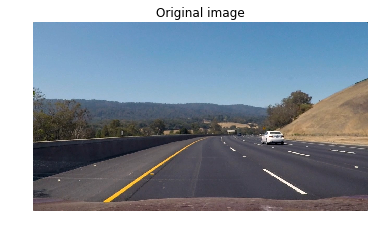

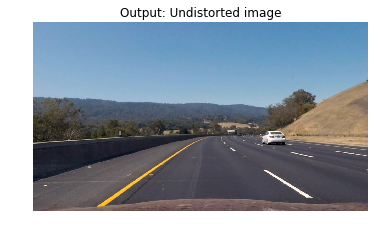

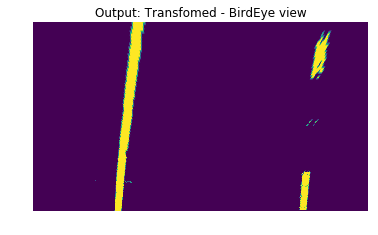

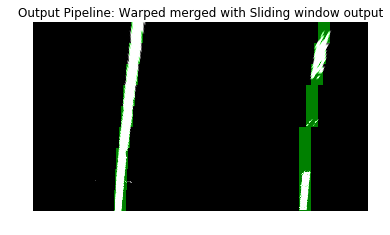

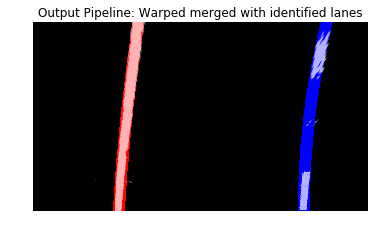

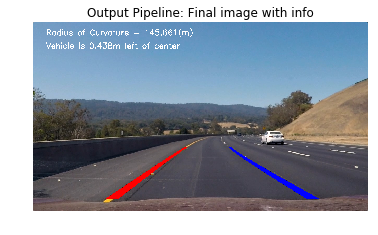

In [47]:
testImage_DIR = '11-input-centerCamera-testImages/'
testImage_sample_FILE = 'test3.jpg'

img = mpimg.imread(testImage_DIR + testImage_sample_FILE)
_ = pipelineAdvancedLaneFinding(img, True)

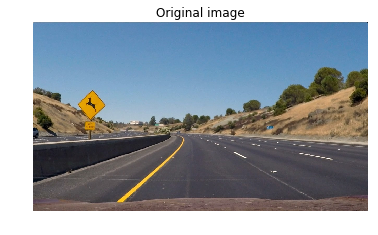

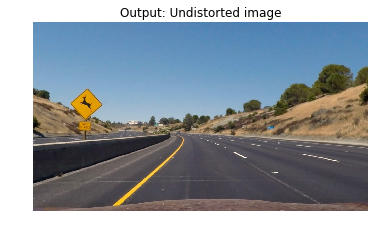

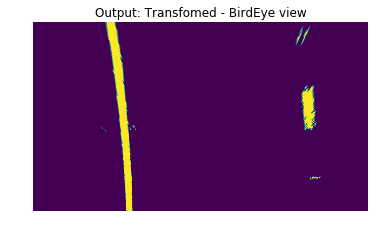

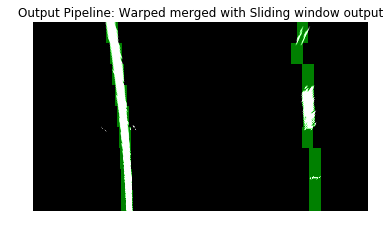

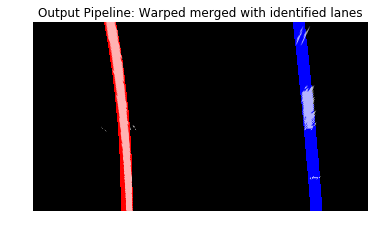

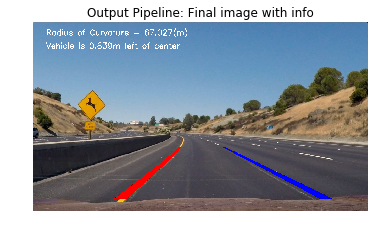

In [51]:
testImage_DIR = '11-input-centerCamera-testImages/'
testImage_sample_FILE = 'test2.jpg'

img = mpimg.imread(testImage_DIR + testImage_sample_FILE)
_ = pipelineAdvancedLaneFinding(img, True)

### Rubric: Pipeline (test images) 
- **Criteria**: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
- **Acceptance criteria**: The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.
- **Output**: **PASS** 

> **HMA**: For a compairison for image input - pipeline output for all sample images, please refer to the following section.

## Pipeline - Set images - Visualization input/output
This visualization section presents the original images and the pipeline output for each of the images at the Sample images set.
> Note: Smooth_factor of 1 for single image run

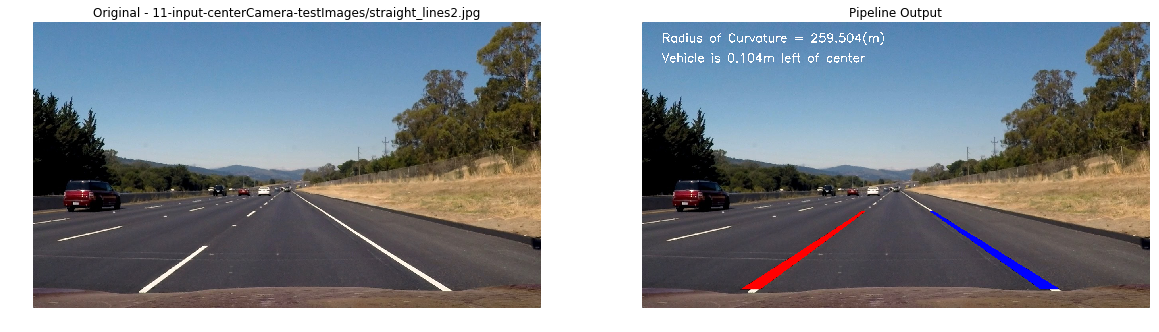

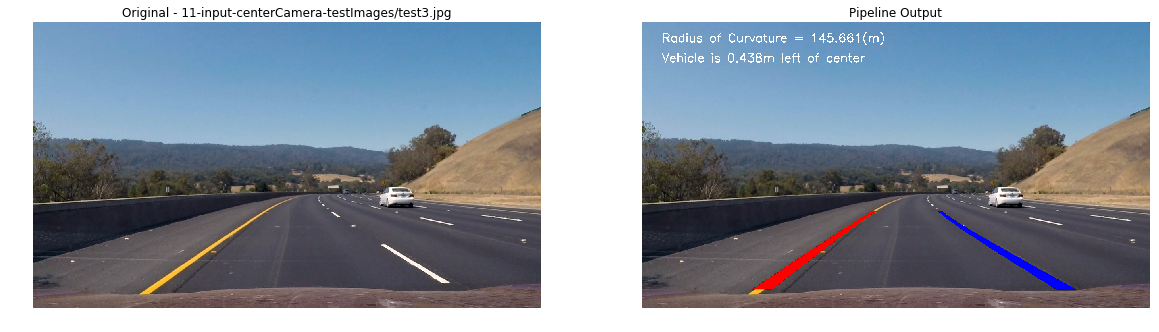

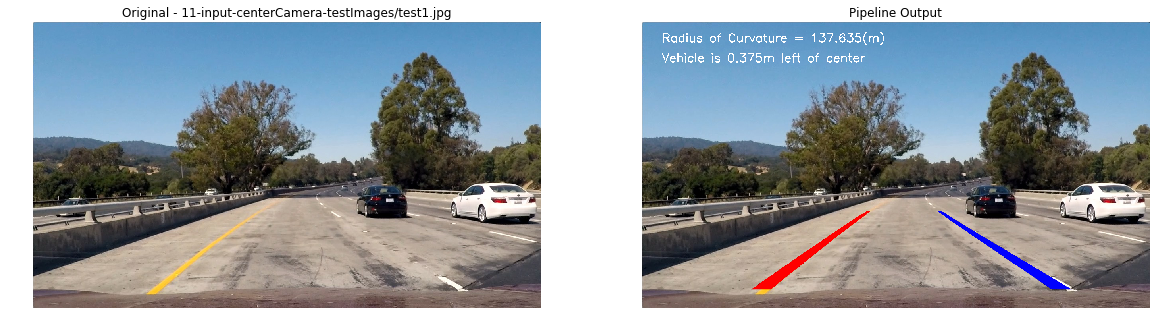

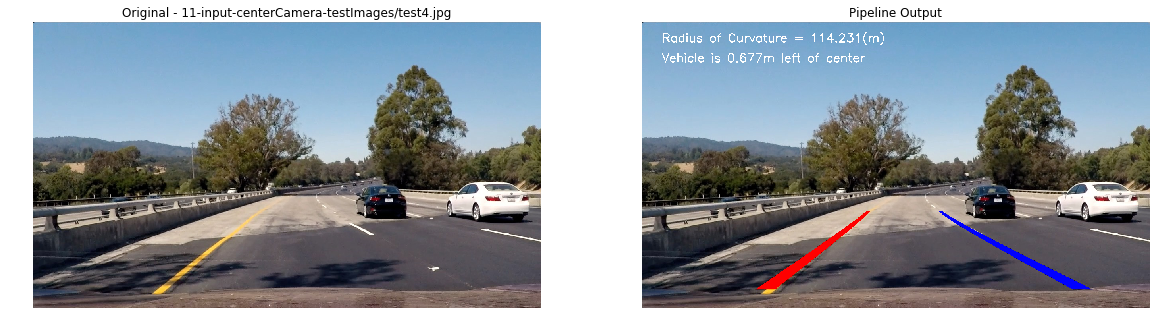

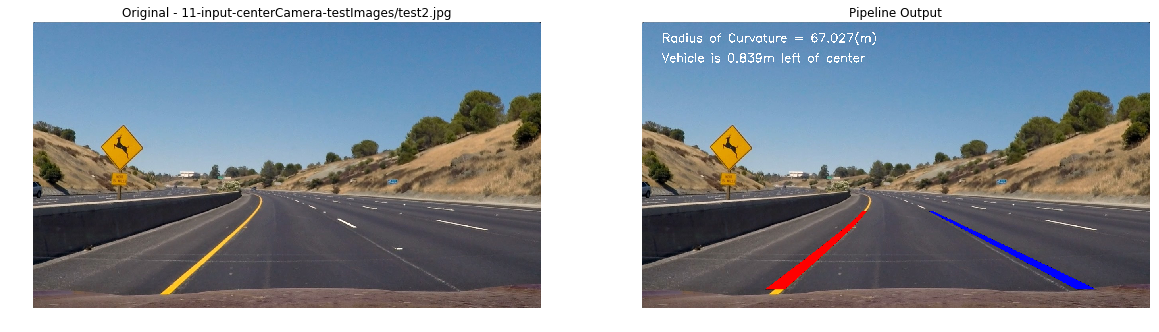

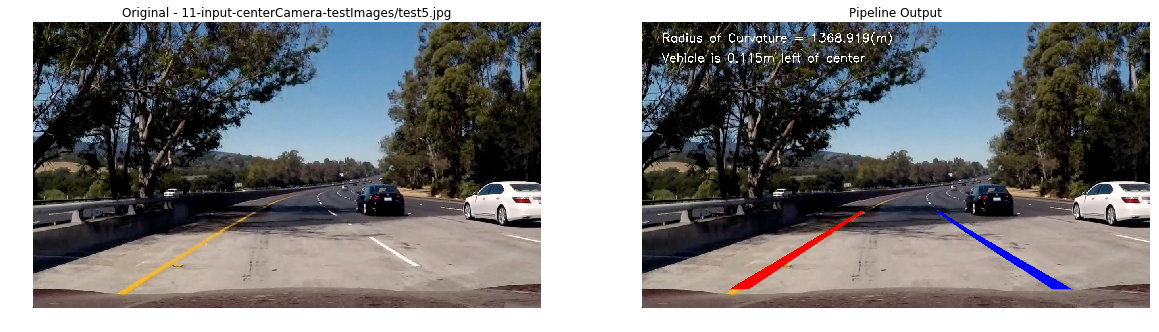

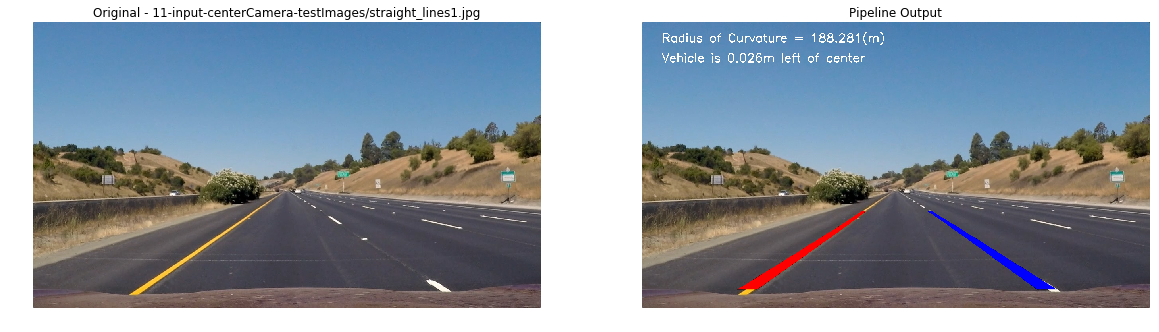

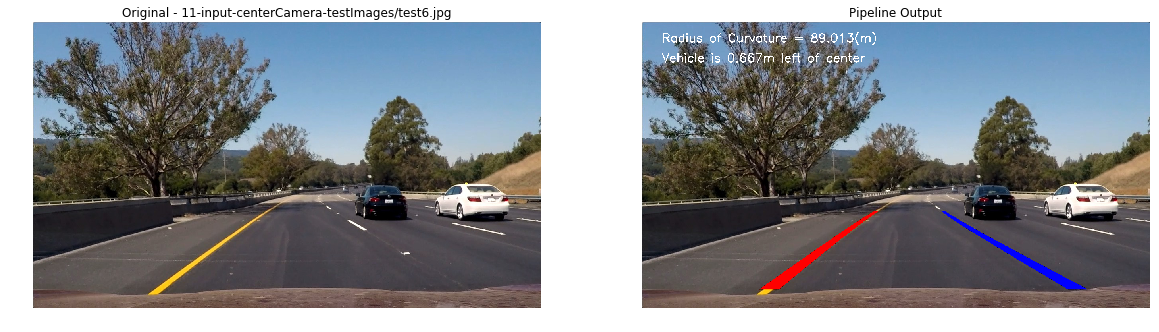

In [54]:
import glob
import os
images = glob.glob(testImage_DIR + '*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    out = pipelineAdvancedLaneFinding(img, False)
    file = os.path.basename(fname)
    pltCompare(img, 'Original - {}'.format(fname), out, 'Pipeline Output')


### Rubric: Pipeline (video)
- **Criteria**: Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)
- **Acceptance criteria**: The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project. 
- **Output**: **PASS** 

> **HMA**: Please find at this same directory, the video file output: [20-output-projectVideo.mp4](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/11-proj-advancedLaneFinding/20-output-projectVideo.mp4).

## Pipeline - Video - Visualization pipeline
The following section presents the video processing using the detailed pipeline.
> Note: Smooth_factor of 20 for video run - Averaging last 20 frames

In [20]:
def process_image(image):
    return pipelineAdvancedLaneFinding(image, False)

In [48]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = '20-output-projectVideo.mp4'
clip = VideoFileClip('10-input-projectVideo.mp4')
video_output_clip = clip.fl_image(process_image)
%time video_output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video 20-output-projectVideo.mp4
[MoviePy] Writing video 20-output-projectVideo.mp4


100%|█████████▉| 1260/1261 [13:00<00:00,  1.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 20-output-projectVideo.mp4 

CPU times: user 16min 34s, sys: 3.67 s, total: 16min 38s
Wall time: 13min 2s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))